# Reinforcement Learning - Temporal Difference
If you want to test/submit your solution **restart the kernel, run all cells and submit the td_autograde.py file into codegrade.**

In [1]:
# This cell imports %%execwritefile command (executes cell and writes it into file). 
# All cells that start with %%execwritefile should be in td_autograde.py file after running all cells.
from custommagics import CustomMagics
get_ipython().register_magics(CustomMagics)

In [2]:
%%execwritefile td_autograde.py
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

Overwriting td_autograde.py


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## 1. Temporal Difference (TD) learning

For the TD algorithms, we will skip the prediction algorithm and go straight for the control setting where we optimize the policy that we are using. To keep it dynamic, we will use the windy gridworld environment (Example 6.5).

In [4]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()
?env.step

Signature: env.step(a)
Docstring:
Run one timestep of the environment's dynamics. When end of
episode is reached, you are responsible for calling `reset()`
to reset this environment's state.

Accepts an action and returns a tuple (observation, reward, done, info).

Args:
    action (object): an action provided by the environment

Returns:
    observation (object): agent's observation of the current environment
    reward (float) : amount of reward returned after previous action
    done (boolean): whether the episode has ended, in which case further step() calls will return undefined results
    info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
File:      ~/anaconda3/envs/rl2020/lib/python3.7/site-packages/gym/envs/toy_text/discrete.py
Type:      method


Implement the EpsilonGreedyPolicy class which uses Q-values to sample an action.

In [25]:
%%execwritefile -a td_autograde.py

class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        if random.random() > self.epsilon:
            action = np.argmax(self.Q[obs])
        
        else:
            action = random.randrange(len(self.Q[obs]))
        return action

Appending to td_autograde.py


Now implement SARSA algorithm.

In [26]:
%%execwritefile -a td_autograde.py

def sarsa(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    
    for i_episode in tqdm(range(num_episodes)):
        s_0 = env.reset()
        a_0 = policy.sample_action(s_0)
        s_1, r, done, info = env.step(a_0)

        i = 1
        R = r

        while not done:
            a_1 = policy.sample_action(s_1)
            Q[s_0, a_0] += alpha * (r + discount_factor * Q[s_1, a_1]
                                      - Q[s_0, a_0])
            a_0, s_0 = a_1, s_1
            s_1, r, done, info = env.step(a_0)

            i += 1
            R += r
        
        Q[s_0, a_0] += alpha * (r - Q[s_0, a_0])        
        stats.append((i, R))

    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Appending to td_autograde.py


In [27]:
def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n


100%|██████████| 1000/1000 [00:00<00:00, 1304.42it/s]

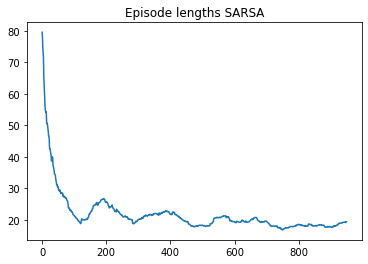

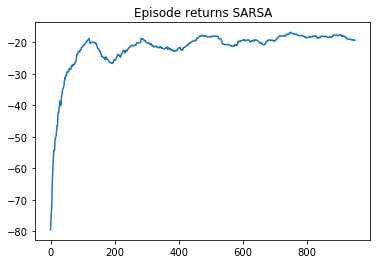

In [28]:
Q = np.zeros((env.nS, env.nA))
policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, policy, Q, 1000)

n = 50
# We will help you with plotting this time
plt.plot(running_mean(episode_lengths_sarsa,n))
plt.title('Episode lengths SARSA')
plt.show()
plt.plot(running_mean(episode_returns_sarsa,n))
plt.title('Episode returns SARSA')
plt.show()

We can also learn the optimal (non-exploring) policy while using another policy to do exploration, which is where we arrive at _off-policy_ learning. In the simplest variant, we learn our own value by bootstrapping based on the action value corresponding to the best action we could take, while the exploration policy actual follows the $\epsilon$-greedy strategy. This is known as Q-learning.

In [32]:
%%execwritefile -a td_autograde.py

def q_learning(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        policy: A behavior policy which allows us to sample actions with its sample_action method.
        Q: Q value function
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        s_0 = env.reset()
        done = False

        while not done:
            a = policy.sample_action(s_0)
            s_1, r, done, info = env.step(a)

            max_Q = np.amax(Q[s_1]) if not done else 0
            Q[s_0, a] += alpha * (r + discount_factor * max_Q
                                    - Q[s_0, a])
            s_0 = s_1
            i += 1
            R += r
        
        stats.append((i, R))
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Appending to td_autograde.py



100%|██████████| 1000/1000 [00:00<00:00, 1038.27it/s]

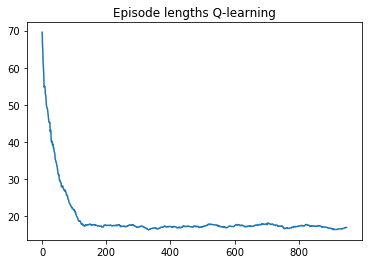

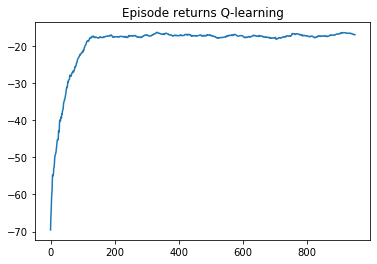

In [33]:
Q = np.zeros((env.nS, env.nA))
policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, policy, Q, 1000)

n = 50
# We will help you with plotting this time
plt.plot(running_mean(episode_lengths_q_learning,n))
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(running_mean(episode_returns_q_learning,n))
plt.title('Episode returns Q-learning')
plt.show()

# Comparing episode returns during training

You will now compare the episode returns while learning for Q-learning and Sarsa by plotting the returns for both algorithms in a single plot, like in the book, Example 6.6. In order to be able to compare them, we will smooth the returns (e.g. plot the $n$ episode average instead).

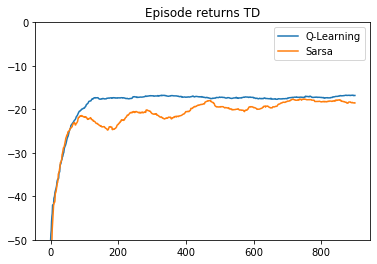

In [34]:
def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

n = 100
plt.plot(running_mean(episode_returns_q_learning, n))
plt.plot(running_mean(episode_returns_sarsa, n))
plt.title('Episode returns TD')
plt.legend(['Q-Learning', 'Sarsa'])
plt.gca().set_ylim([-50, 0])
plt.show()

If you want to test/submit your solution **restart the kernel, run all cells and submit the td_autograde.py file into codegrade.**